# Introduction

This notebook is dedicated to understanding and implementing tree-based regression models from scratch, using two real-world datasets: the **Hitters dataset** (from the ISLR book) and the **California Housing dataset** (from Scikit-learn).

The primary goal is to explore how features (like cumulative baseball stats or housing characteristics) influence a continuous target variable (e.g., **Salary** in Hitters, **MedHouseVal** in Housing), using a complete learning pipeline built manually without relying on any pre-built regression tree libraries.

### Workflow Highlights

1. **Exploratory Data Analysis (EDA)**:
   - I perform detailed data exploration, including checking for missing values, imputing them, and handling categorical variables via encoding.
   - For the Housing dataset, I manually compute the Pearson correlation matrix and visualize it with a heatmap to understand feature importance.
   - This step ensures meaningful and clean data input for modeling.

2. **Regression Tree**:
   - A custom regression tree is built using a greedy recursive binary split strategy.
   - I implement my own version of cost-complexity pruning to avoid overfitting, and perform hyperparameter tuning using k-fold cross-validation.
   - The model is evaluated using metrics like RSS, MSE, and R² on both training and test data.
   - I use multiple diagnostic plots (residual plots, histograms, feature-wise residuals) to understand model performance.

3. **Random Forest**:
   - I build a complete random forest algorithm by combining bootstrapping with feature subsampling.
   - Each tree is trained independently, and final predictions are averaged across all trees.
   - I tune hyperparameters like the number of trees, tree depth, and max features using a custom tuning function.

4. **XGBoost**:
   - A full boosting framework is implemented where each tree learns to predict residuals from previous trees.
   - The trees are shallow (often stumps) and predictions are incrementally updated using a learning rate.
   - I evaluate the improvement in performance over the basic regression tree using the same metrics.
   - Hyperparameter tuning is done for number of estimators, depth, and learning rate.

5. **Model Comparison and Tuning**:
   - I tune both Random Forest and XGBoost using grid search to find the best-performing configuration.
   - The results are compared side-by-side using train/test R² values.
   - This helps assess the trade-offs between bias, variance, training time, and prediction accuracy.

By the end of this notebook, I not only understand how decision trees make predictions, but also how ensemble methods like Random Forest and XGBoost can significantly boost performance both in theory and practice.



Dataset Overview
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
0    29      14      A        E      446       33      20     NaN         A  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N  
4    46      33      N        E      805       40       4    91.5         N  
Shape: (322, 20)

Column Info
<cl

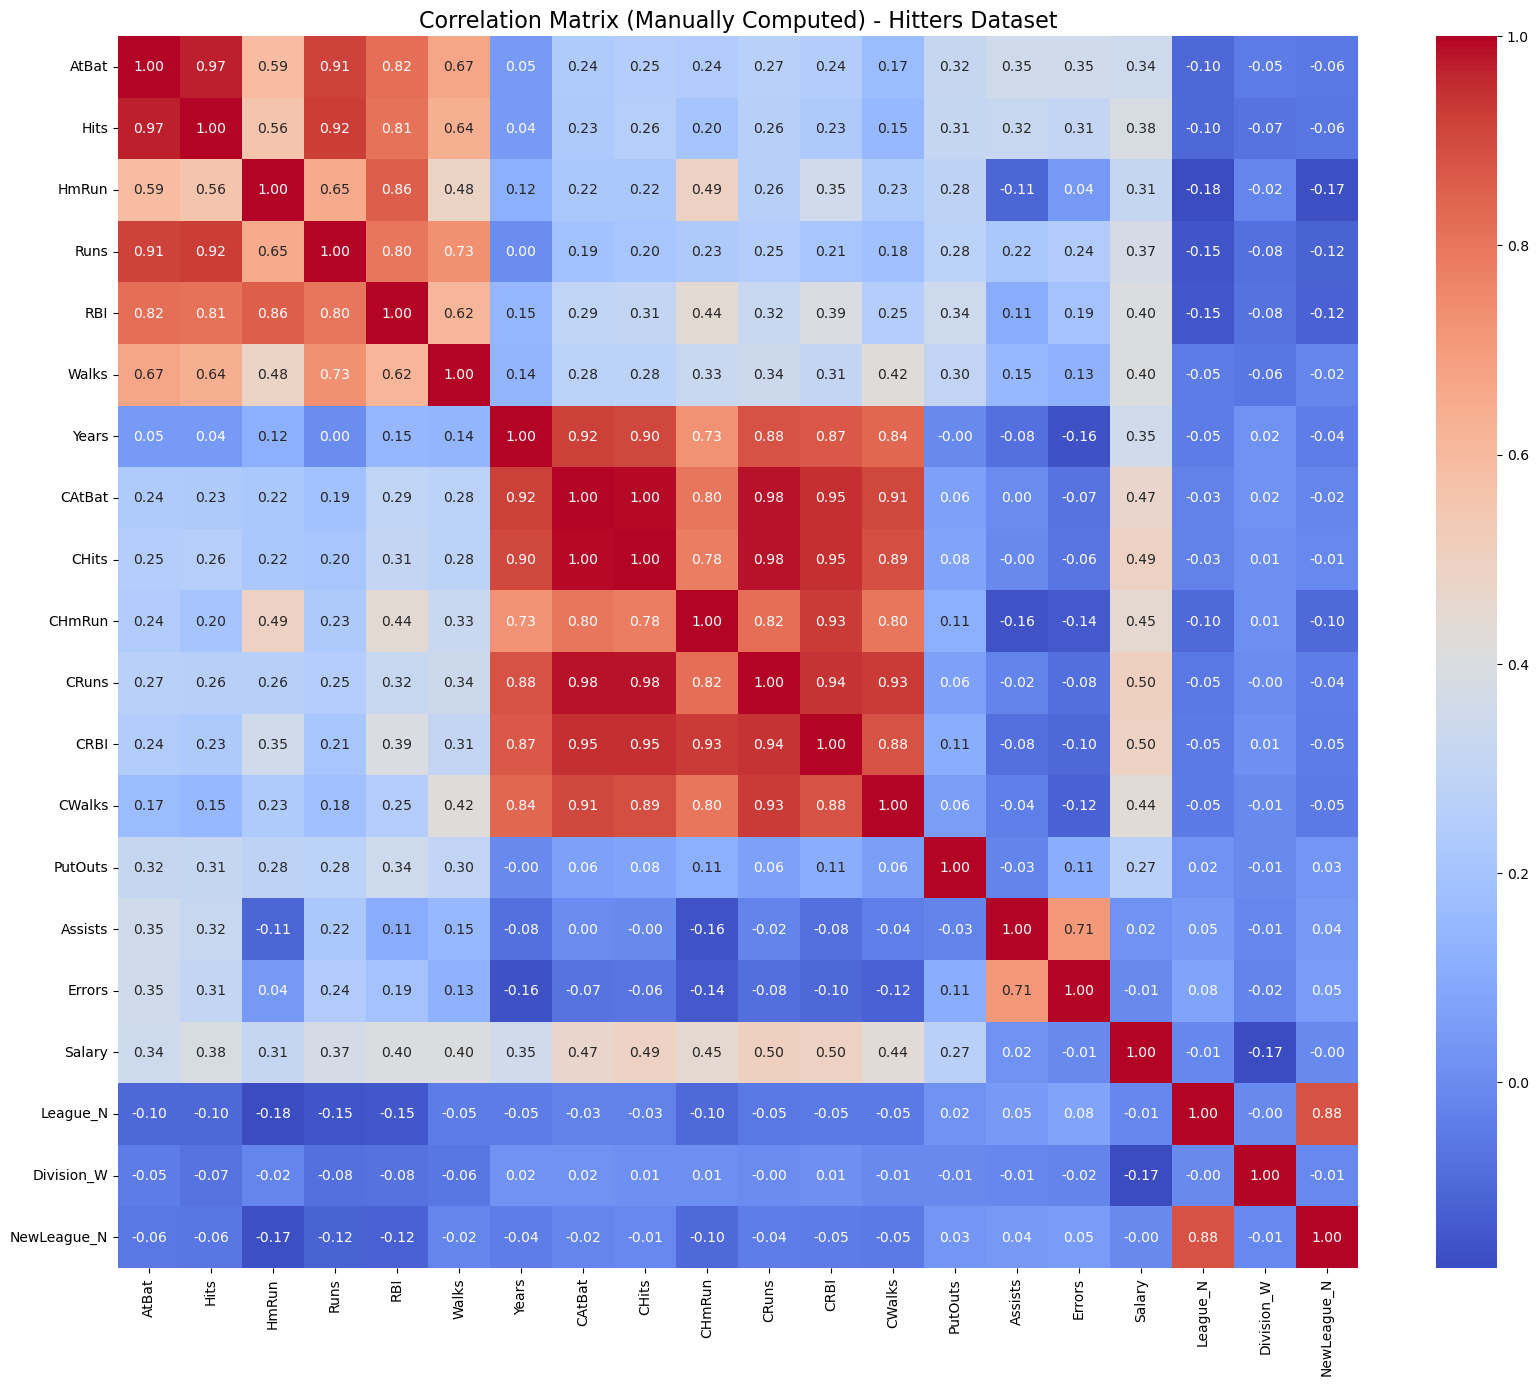


Correlation with Target (Salary)
Salary         1.000000
CRuns          0.503921
CRBI           0.497074
CHits          0.491152
CAtBat         0.467636
CHmRun         0.451876
CWalks         0.437549
Walks          0.402465
RBI            0.401647
Hits           0.384974
Runs           0.372257
Years          0.352235
AtBat          0.342474
HmRun          0.311615
PutOuts        0.270721
Assists        0.024361
NewLeague_N   -0.002566
Errors        -0.005062
League_N      -0.012935
Division_W    -0.174008
Name: Salary, dtype: float64

Response Variable: Salary
Predictor Variables (19): ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W', 'NewLeague_N']


In [ ]:
# Import Important  libraries for All models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# Load the dataset
Hitters = pd.read_csv("All Sample Data/Sample Data/Hitters.csv")

# Drop unnecessary index column if present
if "Unnamed: 0" in Hitters.columns:
    Hitters.drop(columns=["Unnamed: 0"], inplace=True)

# Display basic info
print("\nDataset Overview")
print(Hitters.head())
print(f"Shape: {Hitters.shape}")
print("\nColumn Info")
print(Hitters.info())
print("\nSummary Statistics")
print(Hitters.describe())

# Check and handle missing values
print("\nMissing Values")
print(Hitters.isnull().sum())

# Fill numeric columns with mean
Hitters.fillna(Hitters.mean(numeric_only=True), inplace=True)

# Fill categorical columns with mode
for col in Hitters.select_dtypes(include='object'):
    mode_val = Hitters[col].mode()[0]
    Hitters[col] = Hitters[col].fillna(mode_val)

# Confirm no missing values remain
print("\nAfter Handling Missing Values")
print(Hitters.isnull().sum())

# Encode categorical variables
cat_cols = Hitters.select_dtypes(include='object').columns.tolist()
Hitters = pd.get_dummies(Hitters, columns=cat_cols, drop_first=True)

# Convert boolean columns to integers
bool_cols = Hitters.select_dtypes(include='bool').columns
Hitters[bool_cols] = Hitters[bool_cols].astype(int)

# Manually compute Pearson correlation matrix
features = Hitters.columns
correlation_matrix = pd.DataFrame(index=features, columns=features)

for i in features:
    for j in features:
        xi = Hitters[i] - Hitters[i].mean()
        xj = Hitters[j] - Hitters[j].mean()
        numerator = np.sum(xi * xj)
        denominator = np.sqrt(np.sum(xi ** 2)) * np.sqrt(np.sum(xj ** 2))
        correlation_matrix.loc[i, j] = numerator / denominator

# Convert to float for heatmap
correlation_matrix = correlation_matrix.astype(float)

# Plot heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Manually Computed) - Hitters Dataset", fontsize=16)
plt.show()

# Correlation with target variable (Salary)
print("\nCorrelation with Target (Salary)")
Salary_corr = correlation_matrix["Salary"].sort_values(ascending=False)
print(Salary_corr)

# Separate response and predictor variables
response = "Salary"
predictors = [col for col in Hitters.columns if col != response]
print(f"\nResponse Variable: {response}")
print(f"Predictor Variables ({len(predictors)}): {predictors}")


# Simple Regression Tree

1. A regression tree partitions the predictor space into **non-overlapping rectangular regions** R₁, R₂, ..., Rⱼ.
2. For each region, the prediction is the **mean of the target variable (response)** within that region.
3. The model is built using a **top-down, greedy approach** called **Recursive Binary Splitting**.
4. At each node, the algorithm selects the **predictor and cutpoint** that result in the **largest reduction in RSS** (Residual Sum of Squares).
5. The splitting continues until a **stopping criterion** is met, such as **minimum number of samples** in a leaf or **maximum depth**.
6. A fully grown tree can capture noise and lead to **overfitting**.
7. To avoid this, we apply **cost-complexity pruning**, which penalizes larger trees using a tuning parameter **α (alpha)**.
8. The optimal α is chosen using **K-fold cross-validation** to find the subtree with **lowest estimated test error**.
9. A well-pruned tree has **lower variance**, is **simpler to interpret**, and often **generalizes better**.
10. Regression trees are naturally suited for **non-linear** and **interaction-heavy** data, and they handle both continuous and categorical inputs well.

> Here I used only **four predictors** — CRuns, CRBI, CHits, and CAtBat — from the *Hitters* dataset, because these features are **highly correlated with the Salary**, as seen in the correlation analysis. This smaller feature set allows for a **clearer understanding** of how the tree algorithm splits and predicts.


In [129]:
# Selecting 4 predictors

x=Hitters[['CRuns','CRBI','CHits','CAtBat']]
x_name=x.columns.tolist() # use for plotting 
# Convert Salary into log values maintaining the distribution
y=np.log(Hitters['Salary'].values) # .values convert into array

# Now Combine predictors and response for easier processing in a data
data = pd.concat([x, pd.Series(y, name="response")], axis=1)




# Helper Functions for Tree Evaluation and Structure

In this cell, I have created all the helper functions that will be used later for evaluating the model and understanding the structure of the decision tree.

- **compute_rss**: This function calculates the Residual Sum of Squares (RSS), which is used to measure the error between predicted and actual values.
- **predict_tree**: A recursive function that predicts the output for a single observation by traversing the decision tree from the root to a leaf node.
- **batch_predict**: This function uses the above **predict_tree** for every row in the dataset to make predictions efficiently using **numpy**.
- **compute_tree_rss**: Calculates the total RSS for the tree predictions on the full dataset.
- **count_leaves**: Counts how many leaf nodes are present in the decision tree.
- **get_tree_depth**: Computes the maximum depth (height) of the tree, which helps to understand the complexity of the tree.
- **count_internal_nodes**: Counts how many internal (non-leaf) nodes are present, giving a sense of how many splits the model has made.

These functions are important for evaluating the model’s performance and also for visualizing or understanding the size and depth of the tree later.


In [130]:
# calculate RSS
def compute_rss(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)
## Compute the prediction of tree
def predict_tree(tree, row):
    if tree["type"] == "leaf":
        return tree["prediction"]
    if row[tree["feature"]] < tree["split_val"]:
        return predict_tree(tree["left"], row)
    else:
        return predict_tree(tree["right"], row)
    
# Calculate Prediction of tree using numpy so that its evaluation more faster
def batch_predict(tree, data):
    return np.array([predict_tree(tree, row) for _, row in data.iterrows()])
# Compute Tree RSS
def compute_tree_rss(tree, data):
    preds = batch_predict(tree, data)
    return compute_rss(data["response"].values, preds)
# Count the tree leaves
def count_leaves(tree):
    if tree["type"] == "leaf":
        return 1
    return count_leaves(tree["left"]) + count_leaves(tree["right"])
# Compute tree depth
def get_tree_depth(tree):
    if tree["type"] == "leaf":
        return 1
    return 1 + max(get_tree_depth(tree["left"]), get_tree_depth(tree["right"]))

# Count internal nodes
def count_internal_nodes(tree):
    if tree["type"] == "leaf":
        return 0
    return 1 + count_internal_nodes(tree["left"]) + count_internal_nodes(tree["right"])

# Recursive Tree Growing using Binary Splits
In this cell, I have written the main logic for growing the regression tree using the greedy recursive binary splitting approach.
- First, I created a helper function **find_best_split**. This function checks every predictor and all possible cutpoints (split values) to find the split that gives the lowest RSS. It avoids unnecessary calculations by limiting to 100 unique values if there are too many, and it skips splits that result in an empty region.
- Then, I defined the **grow_tree** function. This is the main recursive function that builds the tree. It stops growing when the number of samples in the data is smaller than **min_samples_split** or when the maximum depth is reached.
- Inside **grow_tree**, it calls **find_best_split** to get the best split point. If no good split is found, it creates a leaf node.
- Otherwise, it splits the data into left and right parts based on the best split found, and then it calls itself recursively for the left and right branches.
This process continues until the stopping condition is met, and the final output is a nested dictionary structure that represents the entire tree.


In [131]:
# Now i am going to apply greedy Recursive Binary Split Approach to get full tree 
# This function heps to best split a region this is a helper function we use it in main grow tree function
def find_best_split(data, predictors):
    best_rss = float("inf") # Assign with infinite 
    best_split = None 
    y=data["response"].values
    for feature in predictors: # Checking for all predictors and there best cutpoints
        unique_values = np.unique(data[feature].values) # Unique value in each predictor
        if len(unique_values)>100 :
            unique_values = np.random.choice(unique_values, 100, replace=False)
        for s in unique_values:
            left = data[feature].values< s # select that data where this condition is true
            right = ~left
            if np.sum(left) == 0 or np.sum(right) == 0: # Checking the emptyness of region
                continue
            y_left=y[left]
            y_right=y[right]
            y_left_pred = y_left.mean()
            y_right_pred = y_right.mean()
            rss = compute_rss(y_left, y_left_pred) + compute_rss(y_right, y_right_pred)
            if rss < best_rss:
                best_rss = rss
                best_split = { # Dictionary to store the information 
                    "feature": feature,
                    "split_val": s,
                    "rss": rss,
                    "left_mean": y_left_pred,
                    "right_mean": y_right_pred,
                    "left_region":left,
                    "right_region":right
                }
    return best_split

# This is the main function which calculate the complete grow tree
def grow_tree(data, predictors, min_samples_split=20, depth=0,max_depth=5):
    # Stopping condition
    if len(data) < min_samples_split or depth>=max_depth :
        return {
            "type": "leaf",
            "prediction": data["response"].mean(),
            "samples": len(data),
            "depth": depth
        }

    # Find best split
    best_split = find_best_split(data, predictors)
    if not best_split: # if no best split is possible 
        return {
            "type": "leaf",
            "prediction": data["response"].mean(),
            "samples": len(data),
            "depth": depth
        }
    # Recursively grow left and right branches
    left_data = data[data[best_split["feature"]] < best_split["split_val"]]
    right_data = data[data[best_split["feature"]] >= best_split["split_val"]]
    return {
        "type": "node",
        "feature": best_split["feature"],
        "split_val": best_split["split_val"],
        "left": grow_tree(left_data, predictors, min_samples_split, depth + 1),
        "right":grow_tree(right_data, predictors, min_samples_split, depth + 1),
        "depth": depth
    }

# Cost Complexity Pruning (Tree Simplification)

In this cell, I have written the logic to simplify the full tree using a method called **cost complexity pruning**. This helps reduce overfitting by cutting back unnecessary splits and controlling the variance of the model.

- The function **select_best_subtree_by_cost** helps to choose the best subtree from a list of pruned versions of the original tree. It does this by calculating a cost function:  
  **cost = RSS + α × (number of leaves)**  
  Here, **RSS** is the residual sum of squares, and **α (alpha)** is a penalty term for complexity.  
  The function selects the subtree with the lowest total cost.

- The function **prune_tree_once** tries to prune the tree one level at a time:  
  - If both left and right child nodes are leaves, it replaces them with a single new leaf.  
  - The new leaf’s prediction is the weighted average of the two original leaves.  
  - If it cannot prune at the current level, it tries pruning in the left or right branches.

- The function **generate_pruning_sequence** calls **prune_tree_once** again and again in a loop.  
  - Each time it simplifies the tree one step further and saves the resulting tree in a list.  
  - This gives us a full pruning path: a sequence of trees from most complex to most simple.

These functions allow me to control tree complexity and select a tree that balances prediction accuracy and simplicity using the concept of alpha (regularization strength).


In [132]:
# Now make a function which prune the cost complexity for give some penality to reduce the varience
# Prune using cost complexity pruning
# Prune a tree by turning lowest-gain internal node into a leaf
def select_best_subtree_by_cost(pruning_sequence, data, alpha):
    best_subtree = None
    best_cost = float("inf")

    for subtree in pruning_sequence:
        rss = compute_tree_rss(subtree, data)
        leaves = count_leaves(subtree)
        cost = rss + alpha * leaves

        if cost < best_cost:
            best_cost = cost
            best_subtree = subtree

    return best_subtree

def prune_tree_once(tree):
    if tree["type"] == "leaf":
        return tree, False

    if tree["left"]["type"] == "leaf" and tree["right"]["type"] == "leaf":
        # Combine into one leaf
        combined_samples = tree["left"]["samples"] + tree["right"]["samples"]
        combined_mean = (
            tree["left"]["prediction"] * tree["left"]["samples"] +
            tree["right"]["prediction"] * tree["right"]["samples"]
        ) / combined_samples
        return {
            "type": "leaf",
            "prediction": combined_mean,
            "samples": combined_samples,
            "depth": tree["depth"]
        }, True

    # Try pruning subtrees
    left_pruned, did_prune_left = prune_tree_once(tree["left"])
    if did_prune_left:
        tree["left"] = left_pruned
        return tree, True

    right_pruned, did_prune_right = prune_tree_once(tree["right"])
    if did_prune_right:
        tree["right"] = right_pruned
        return tree, True

    return tree, False

# Generate pruning path (sequence of subtrees)
def generate_pruning_sequence(tree):
    sequence = [tree]
    current_tree = tree
    while True:
        pruned_tree, did_prune = prune_tree_once(current_tree)
        if not did_prune:
            break
        sequence.append(pruned_tree)
        current_tree = pruned_tree
    return sequence


# Cost Complexity Cross-Validation for Regression Tree

In this cell, I have written two important functions related to **K-Fold Cross-Validation** and **Cost Complexity Pruning** to select the best value of alpha (α), which helps in controlling model complexity.

**1. k_fold_split**  
This function performs manual K-Fold splitting:
- It randomly shuffles the indices of the dataset.
- It then divides the dataset into K equal parts (folds).
- Each fold is used once as a test set, while the remaining K−1 folds are used for training.

This ensures that the model is trained and evaluated on multiple data splits, reducing the chance of overfitting and giving a more reliable estimate of test error.

**2. cost_complexity_cv**  
This function helps select the best pruning level by trying different values of **α (alpha)** using K-Fold cross-validation:
- For each fold:
  - It builds a full regression tree on the training portion.
  - It generates a pruning sequence (i.e., smaller and smaller trees).
  - For each value of **α**, it finds the best pruned subtree and evaluates its performance on the test fold using **RSS (Residual Sum of Squares)**.
- It stores the cross-validation error (MSE) for each **α**.
- At the end, it returns:
  - The best **α** (which gives the lowest average CV error).
  - The list of average errors for each **α** tried.

This process helps in choosing the **simplest** tree that has **good generalization performance**, rather than always picking the most complex tree.



In [140]:
# 5-Fold Cross-Validation
def k_fold_split(data, k=5):
    indices = np.arange(len(data)) # give the indices on each row
    np.random.shuffle(indices)     # shuffle all data to reduce the biasness
    fold_size = len(data) // k     # for integer division
    folds = [indices[i*fold_size:(i+1)*fold_size] for i in range(k-1)]
    folds.append(indices[(k-1)*fold_size:])
    return folds


# Cross-validation for each alpha to find best alpha
def cost_complexity_cv(data, predictors, alpha_values, k, min_samples_split=20,max_depth=5):
    folds = k_fold_split(data, k)
    alpha_errors = {alpha :[] for alpha in alpha_values}
    

    for i in range(k):
        test_idx = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(k) if j != i])

        train_data = data.iloc[train_idx].reset_index(drop=True)
        test_data = data.iloc[test_idx].reset_index(drop=True)

        full_tree = grow_tree(train_data, predictors, min_samples_split,max_depth=max_depth)
        pruning_sequence = generate_pruning_sequence(full_tree)
        # Reuse pruning sequence for each alpha
        for alpha in alpha_values:
            best_subtree = select_best_subtree_by_cost(pruning_sequence, test_data, alpha)
            rss = compute_tree_rss(best_subtree, test_data)
            mse = rss / len(test_data)
            alpha_errors[alpha].append(mse)
    avg_errors = [(alpha, np.mean(errors)) for alpha, errors in alpha_errors.items()]
    best_alpha = min(avg_errors, key=lambda x: x[1])[0]

    return best_alpha, avg_errors

# Selecting the Best Pruned Subtree

In this cell, I have made a function that selects the **best pruned regression tree** based on the value of **alpha (α)** obtained from cross-validation.

**Function: get_best_pruned_subtree**

- First, it grows a full regression tree using the training data.
- Then, it generates a **pruning sequence**, which is a list of progressively simpler trees created by pruning internal nodes one at a time.
- For each tree in this sequence, it calculates:
  - The **RSS (Residual Sum of Squares)** on the full training data.
  - The number of **leaves** in the tree.
  - The total **cost** as: **RSS + α × (number of leaves)**.
- The tree with the **lowest cost** is selected as the best subtree.

This function helps ensure that we use a **simpler tree** with good performance, reducing overfitting by applying a **complexity penalty** through α.

In [135]:
# Function to get best subtree after pruning
def get_best_pruned_subtree(data, predictors, best_alpha, min_samples_split=20,max_depth=5):
    full_tree = grow_tree(data, predictors, min_samples_split,max_depth=max_depth)
    pruning_sequence = generate_pruning_sequence(full_tree)

    best_subtree = None
    best_cost = float("inf")

    for subtree in pruning_sequence:
        rss = compute_tree_rss(subtree, data)
        leaves = count_leaves(subtree)
        cost = rss + best_alpha * leaves

        if cost < best_cost:
            best_cost = cost
            best_subtree = subtree

    return best_subtree


# Plotting Functions

In this cell, I have made functions for different types of plotting which I use later for visualizing and evaluating my regression tree model:

- **plot_predictions_vs_actuals**: to compare actual vs predicted values using a scatterplot.
- **plot_residuals**: to visualize how residuals behave against predicted values.
- **plot_residual_histogram**: to check the distribution of residuals to see if they are centered around zero.
- **plot_error_vs_feature**: to analyze how residuals vary with individual features.
- **plot_alpha_vs_cv_error**: to visualize the effect of different α values on cross-validation error.

These plots help in better model diagnostics and understanding its performance.


In [136]:
# Now i am going to make all type of plot functions 
# 1. Predicted vs Actual Values
def plot_predictions_vs_actuals(y_true, y_pred, title="Predicted vs Actual Values"):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, color='blue', s=50, edgecolor='black')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal Prediction')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 2. Residuals vs Predicted Values
def plot_residuals(y_true, y_pred, title="Residuals vs Predicted"):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals, color='orange', edgecolor='black', s=60)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 3. Distribution of Residuals
def plot_residual_histogram(y_true, y_pred, bins=30, title="Distribution of Residuals"):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=bins, color='skyblue', edgecolor='black')
    plt.axvline(0, color='red', linestyle='--')
    plt.title(title)
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 4. Residual vs feature
def plot_error_vs_feature(y_true, y_pred, feature_values, feature_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=feature_values, y=residuals, color='green', edgecolor='black', s=60)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residuals vs {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 5. Cross Validation Error vs alpha values
def plot_alpha_vs_cv_error(alpha_errors):
    alphas = [x[0] for x in alpha_errors]
    errors = [x[1] for x in alpha_errors]
    
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=alphas, y=errors, marker='o')
    plt.xlabel("Alpha (Complexity Penalty)")
    plt.ylabel("CV Error (MSE)")
    plt.title("Alpha vs Cross-Validated Error")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Complete Pipeline for Regression Tree Evaluation

In this cell, I have made a **complete pipeline to evaluate the performance of a regression tree model**. This function does all the essential steps in a single run from training to evaluation and visualizing the model output.

The key steps done inside the function are:

- **Train/Test Split**: The dataset is divided into training and testing sets.
- **Cross-Validation with Cost-Complexity Pruning**: I use 5-fold CV to select the best α (complexity parameter) that minimizes cross-validated error.
- **Best Subtree Selection**: After getting the best α, I prune the tree and get the best pruned subtree.
- **Model Evaluation**:
  - Compute **RSS** (Residual Sum of Squares), **MSE**, and **R² score** for both training and testing sets.
  - Count the **depth**, **number of leaves**, and **internal nodes** of the tree.
- **Visualization**:
  - Plot actual vs predicted values to check how close the predictions are.
  - Plot residuals vs predictions and vs features to detect patterns or bias.
  - Plot histogram of residuals to see if residuals are centered around zero.
  - Plot α vs CV error to visualize the pruning impact.

This function brings together all previously defined helper functions into a single evaluation script. It’s useful for comparing trees under different hyperparameters or pruning settings.


In [137]:
# R² score
def r2_score(y_true, y_pred):
    RSS = np.sum((y_true - y_pred) ** 2)
    TSS = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - RSS / TSS
def evaluate_regression_tree(data, predictors,x_name, alpha_values=np.linspace(0, 10, 21), test_size=0.2, random_state=42, min_samples_split=2,max_depth=8):
    # Train/Test Split
    train_df, test_df = train_test_split(data, test_size=test_size, random_state=random_state)

    # Select best alpha using CV on training data
    best_alpha, alpha_errors = cost_complexity_cv(train_df, predictors, alpha_values, k=5, min_samples_split=min_samples_split,max_depth=max_depth)

    # Train best-pruned tree on training data and get best tree 
    best_tree = get_best_pruned_subtree(train_df, predictors, best_alpha, min_samples_split=min_samples_split,max_depth=max_depth)

    # Step 4: Evaluation
    train_rss = compute_tree_rss(best_tree, train_df)
    test_rss = compute_tree_rss(best_tree, test_df)

    train_mse = train_rss / len(train_df)
    test_mse = test_rss / len(test_df)

    tree_depth = get_tree_depth(best_tree)
    n_leaves = count_leaves(best_tree)
    nodes=count_internal_nodes(best_tree)

    y_test = test_df["response"].values
    test_predictions = test_df.apply(lambda row: predict_tree(best_tree, row), axis=1)
    y_test_pred=test_predictions.values
    test_r2 = r2_score(y_test, y_test_pred)
    # Calculating Train R_2 also 
    y_train = train_df["response"].values
    y_tain_pred = train_df.apply(lambda row: predict_tree(best_tree, row), axis=1).values
    train_r2=r2_score(y_train,y_tain_pred)
    # Print the results
    print("Final Regression Tree Evaluation")
    print(f"Best alpha (from CV): {best_alpha}")
    print(f"Tree Depth: {tree_depth}")
    print(f"Internal Nodes: {nodes}")
    print(f"Number of Leaves: {n_leaves}")
    print(f"Train RSS: {train_rss:.2f}")
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Test RSS: {test_rss:.2f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Train R_2 Score: {train_r2:.4f}")
    print(f"Test R_2 Score: {test_r2:.4f}")
    plot_predictions_vs_actuals(y_test,y_test_pred)
    plot_residuals(y_test,y_test_pred)
    plot_residual_histogram(y_test,y_test_pred)
    test_idx=test_df.index
    for i, feature in enumerate(x_name):
        plot_error_vs_feature(
            y_true=y_test,
            y_pred=y_test_pred,
            feature_values=x.loc[test_idx,feature].values,
            feature_name=feature)
    
    plot_alpha_vs_cv_error(alpha_errors)

Final Regression Tree Evaluation
Best alpha (from CV): 0.0
Tree Depth: 2
Internal Nodes: 1
Number of Leaves: 2
Train RSS: 101.81
Train MSE: 0.3962
Test RSS: 22.00
Test MSE: 0.3385
Train R_2 Score: 0.4389
Test R_2 Score: 0.2798


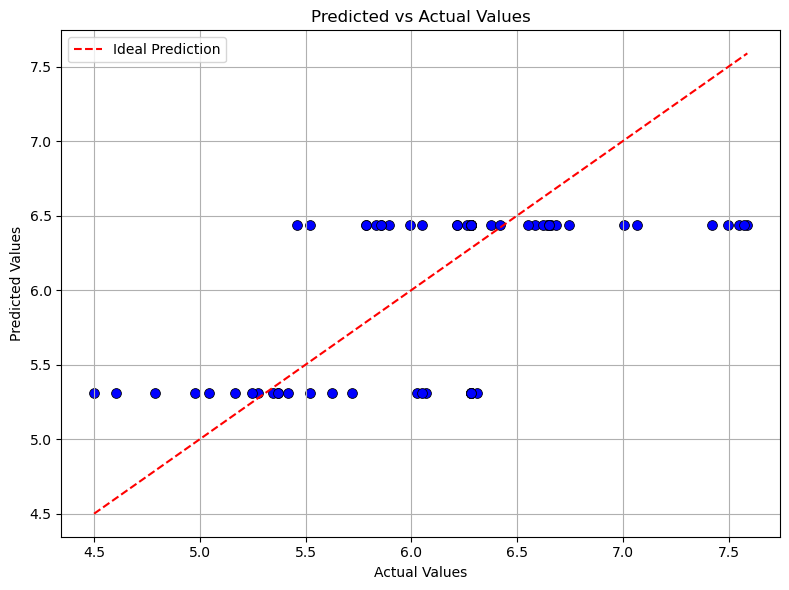

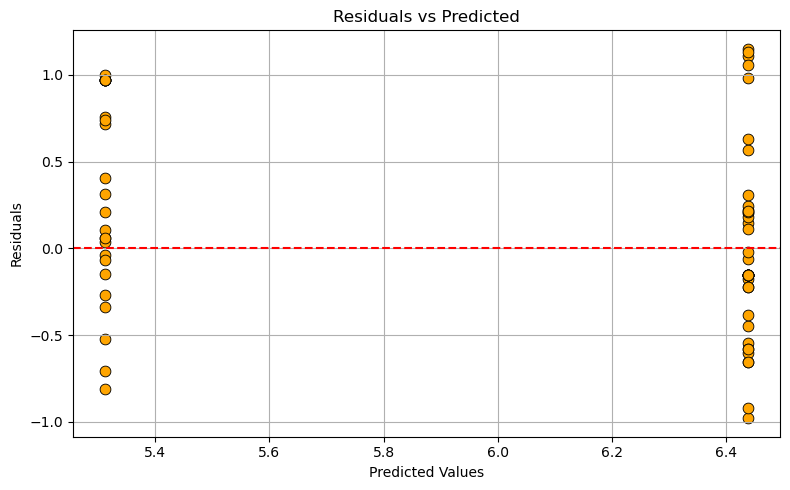

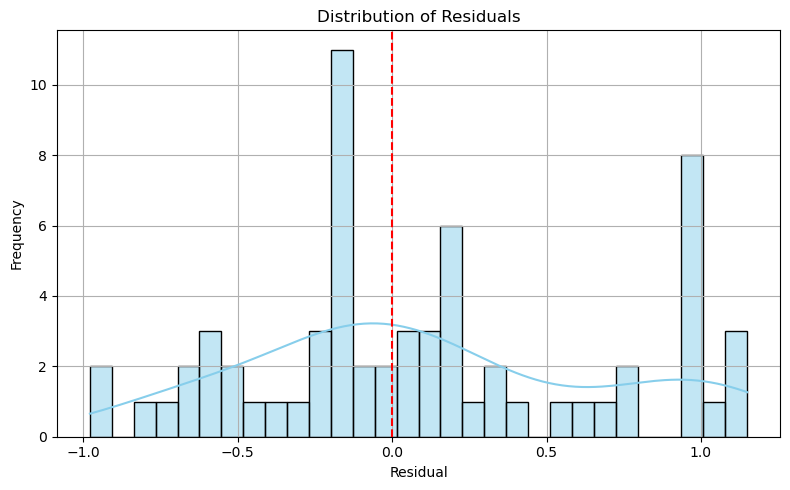

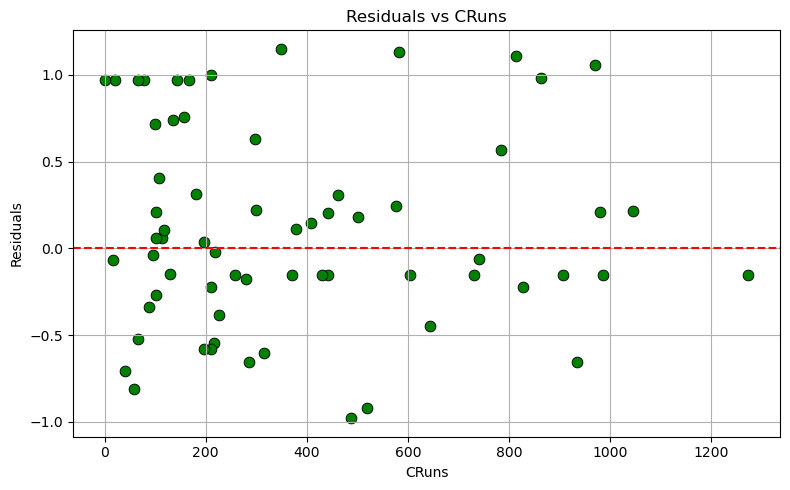

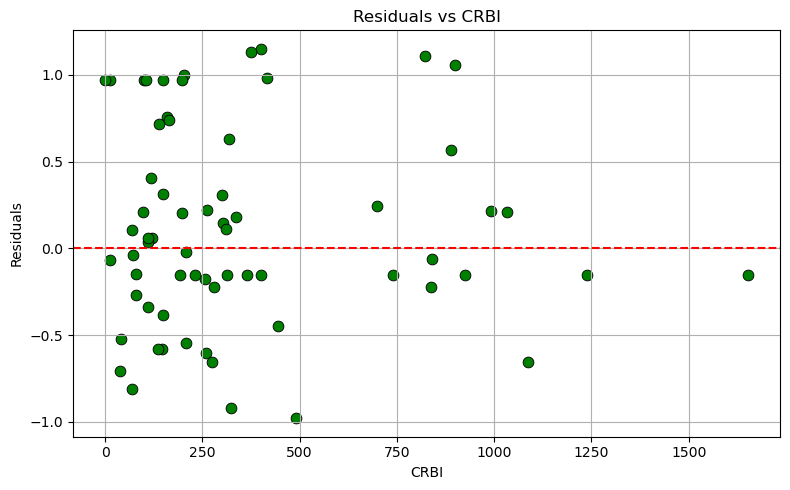

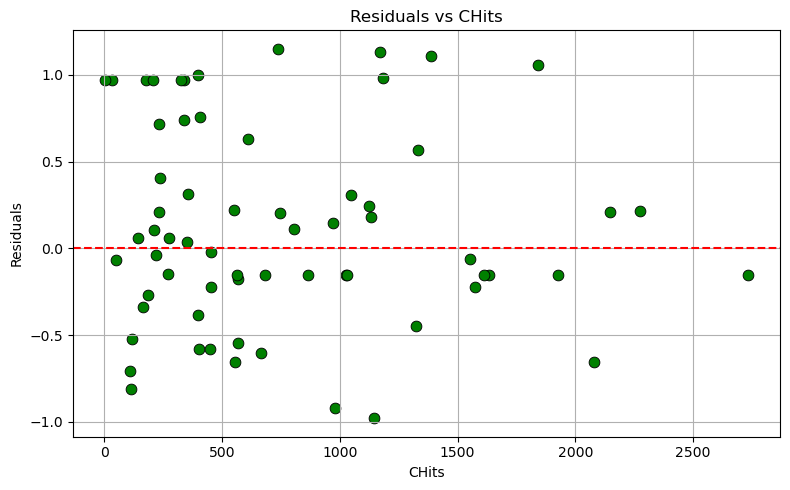

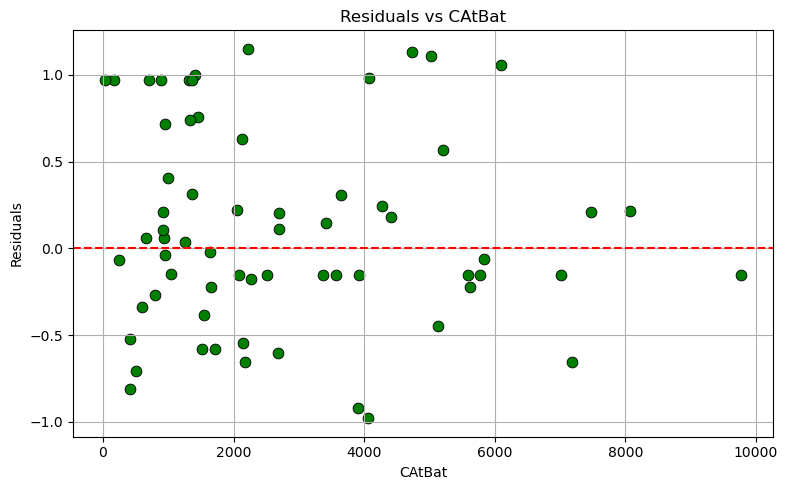

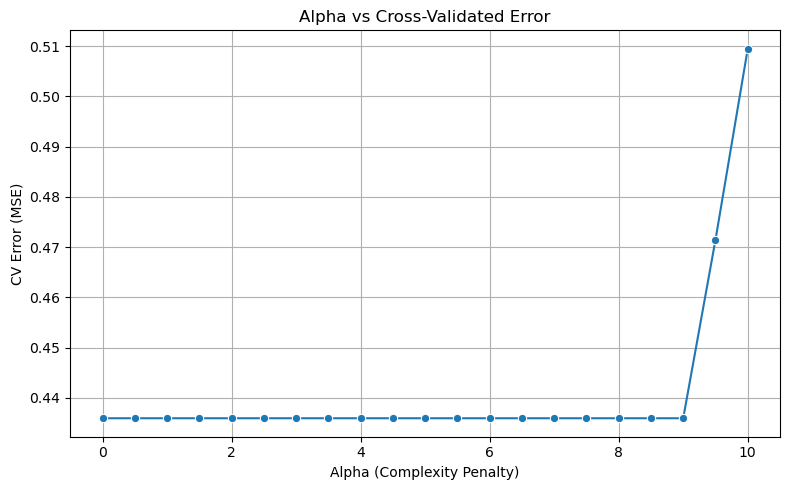

In [ ]:
# Run Regression Tree Model 
evaluate_regression_tree(data,x,x_name)

### California Housing Dataset Preprocessing

Now I am going to use the **California Housing dataset** from the Scikit-learn library for applying **Random Forest** and **XGBoost** models.

In this cell, I first load the dataset and perform basic cleaning steps:
- Checked for and handled any missing values by imputing numeric features with their **mean** and categorical (if any) with **mode**.
- Converted any **categorical columns** using **one-hot encoding**.
- Converted any boolean columns into integers for easier processing in modeling.
- Then, I manually computed the **Pearson correlation matrix** to understand the relationship between all features and the target variable (**MedHouseVal**).
- I visualized the correlation matrix using a heatmap to identify the most relevant predictors.
- Finally, I separated the target variable and predictors for use in training.

This dataset will now be used for building and evaluating **Random Forest** and **XGBoost models from scratch** in the upcoming sections.



Dataset Overview
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  
Shape: (20640, 9)

Column Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   Ave

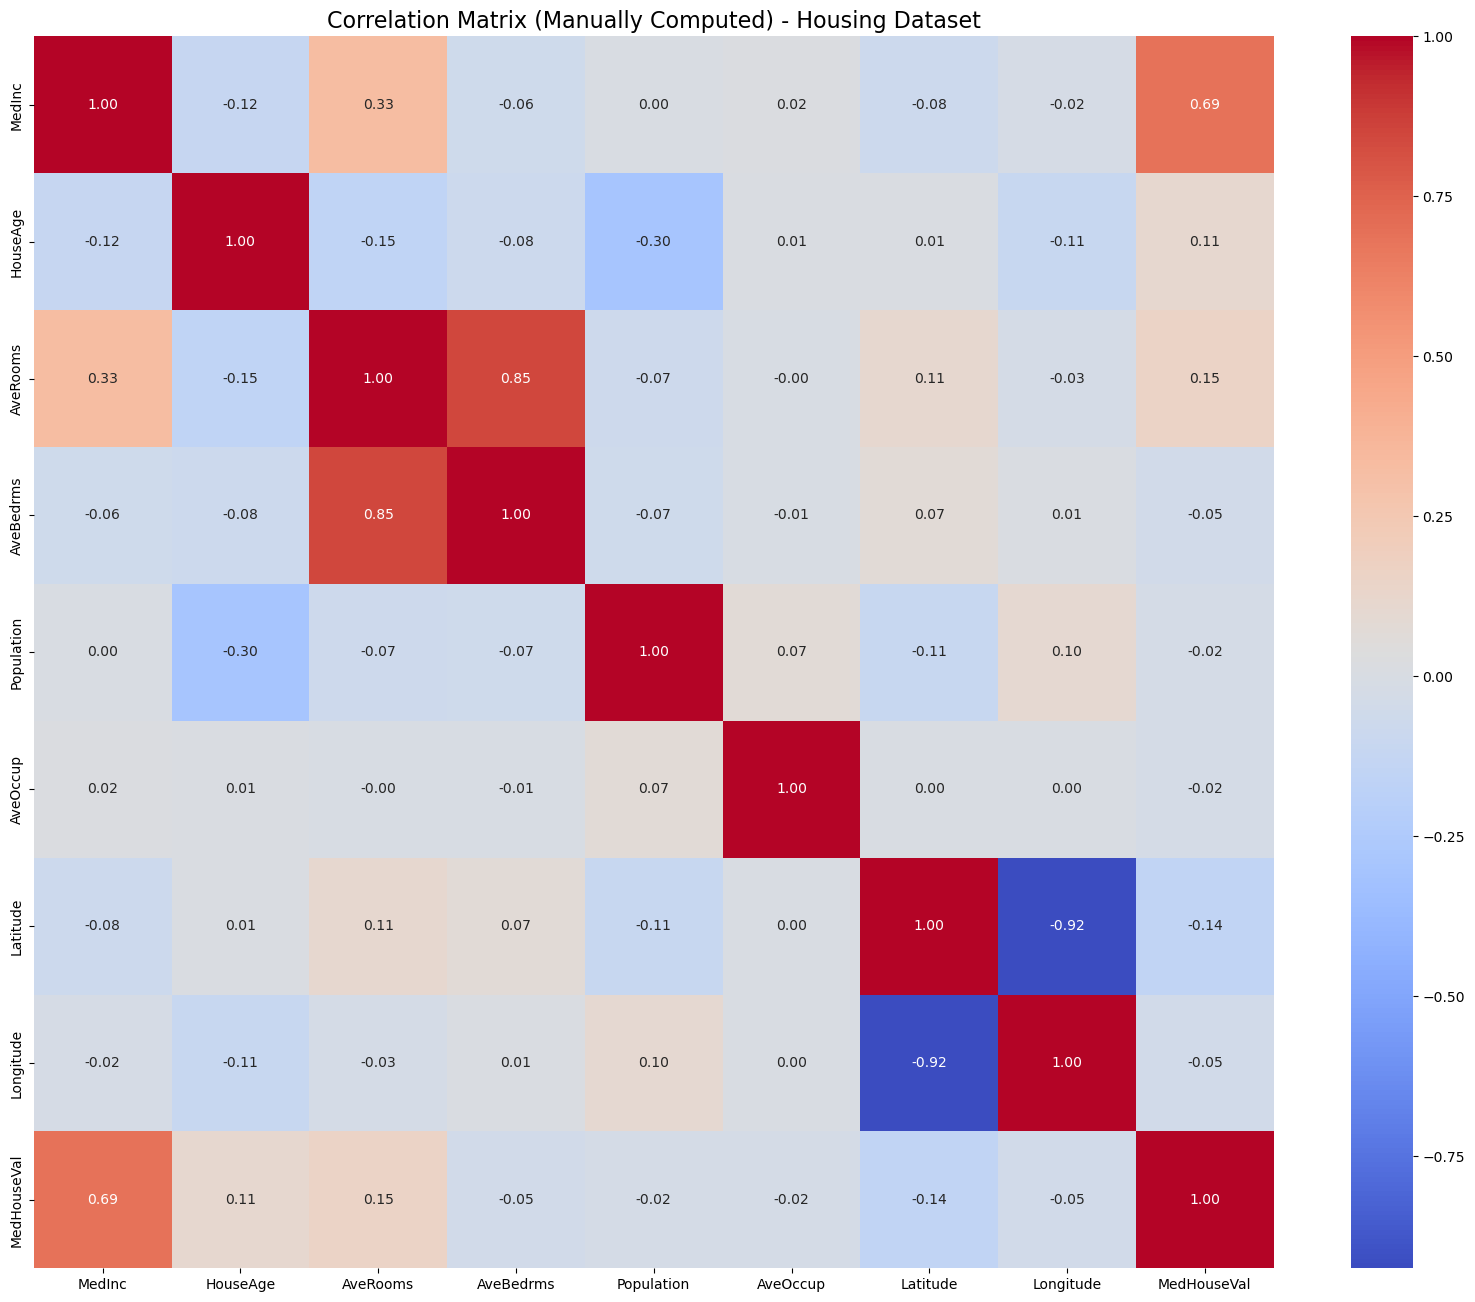


Correlation with Target (MedHouseVal)
MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
HouseAge       0.105623
AveOccup      -0.023737
Population    -0.024650
Longitude     -0.045967
AveBedrms     -0.046701
Latitude      -0.144160
Name: MedHouseVal, dtype: float64

Response Variable: MedHouseVal
Predictor Variables (8): ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [143]:
from sklearn.datasets import fetch_california_housing
import random
# Load the dataset
Housing = fetch_california_housing(as_frame=True)
Housing=Housing.frame
# Drop unnecessary index column if present
if "Unnamed: 0" in Housing.columns:
    Housing.drop(columns=["Unnamed: 0"], inplace=True)

# Display basic info
print("\nDataset Overview")
print(Housing.head())
print(f"Shape: {Housing.shape}")
print("\nColumn Info")
print(Housing.info())
print("\nSummary Statistics")
print(Housing.describe())

# Check and handle missing values
print("\nMissing Values")
print(Housing.isnull().sum())

# Fill numeric columns with mean
Housing.fillna(Housing.mean(numeric_only=True), inplace=True)

# Fill categorical columns with mode
for col in Housing.select_dtypes(include='object'):
    mode_val = Housing[col].mode()[0]
    Housing[col] = Housing[col].fillna(mode_val)

# Confirm no missing values remain
print("\nAfter Handling Missing Values")
print(Housing.isnull().sum())

# Encode categorical variables
cat_cols = Housing.select_dtypes(include='object').columns.tolist()
Housing = pd.get_dummies(Housing, columns=cat_cols, drop_first=True)

# Convert boolean columns to integers
bool_cols = Housing.select_dtypes(include='bool').columns
Housing[bool_cols] = Housing[bool_cols].astype(int)

# Manually compute Pearson correlation matrix
features = Housing.columns
correlation_matrix = pd.DataFrame(index=features, columns=features)

for i in features:
    for j in features:
        xi = Housing[i] - Housing[i].mean()
        xj = Housing[j] - Housing[j].mean()
        numerator = np.sum(xi * xj)
        denominator = np.sqrt(np.sum(xi ** 2)) * np.sqrt(np.sum(xj ** 2))
        correlation_matrix.loc[i, j] = numerator / denominator

# Convert to float for heatmap
correlation_matrix = correlation_matrix.astype(float)

# Plot heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Manually Computed) - Housing Dataset", fontsize=16)
plt.show()

# Correlation with target variable (MedHouseVal)
print("\nCorrelation with Target (MedHouseVal)")
Salary_corr = correlation_matrix["MedHouseVal"].sort_values(ascending=False)
print(Salary_corr)

# Separate response and predictor variables
response = "MedHouseVal"
predictors = [col for col in Housing.columns if col != response]
print(f"\nResponse Variable: {response}")
print(f"Predictor Variables ({len(predictors)}): {predictors}")


### Random Forest :

Random Forest is an **ensemble learning method** that builds multiple decision trees and combines their predictions to improve accuracy and reduce overfitting. It is particularly helpful when a single decision tree is unstable or has high variance.

The main ideas behind Random Forest are:
- **Bootstrap Sampling**: Each tree in the forest is trained on a different random sample (with replacement) from the training data.
- **Feature Subsampling**: At each split in a tree, only a random subset of features is considered. This helps reduce correlation between trees.
- Each tree is **grown deep** without pruning, which ensures low bias.
- Final prediction is done by **averaging** (for regression) or **voting** (for classification) over all trees.

Key advantages of Random Forest:
- **Better performance** than individual trees due to averaging.
- **Less prone to overfitting** than a single large tree.
- **Robust** to noise and outliers.
- **Works well** even when there are strong correlations or nonlinear relationships.

In this cell, I will use the **California Housing dataset** to apply the Random Forest method and XGBoost from scratch. I will also tune the important hyperparameters such as:
- Number of trees (n_trees)
- Maximum depth of each tree (max_depth)
- Number of features to sample at each split (max_features)
- Number of estimator(trees) for XGBoost
- Learning Rate for XGBoost



In [157]:
# Preparing Data and Predictors for Random Forest Method and XGBoosting and their tunning on different Parameter
x1=Housing.drop('MedHouseVal',axis=1)
y1=Housing['MedHouseVal'].values
predictors=x1.columns.tolist()
data = pd.concat([x1, pd.Series(y1, name="response")],axis=1)

### Random Forest Implementation

In this cell, I have implemented the complete Random Forest algorithm from scratch using the following steps:

- **bootstrap_sample**: This function performs bootstrap sampling by randomly selecting observations with replacement from the dataset. Each tree in the forest gets a different sample to learn from, helping to reduce variance.

- **train_random_forest**: This is the main function that builds the forest. For each tree:
  - A bootstrap sample of the data is taken.
  - A random subset of the predictors is selected (feature subsampling).
  - A regression tree is trained using only the selected predictors.
  - The trained tree along with its subset of features is stored in the forest list.

- **predict_forest**: This function makes predictions using the entire forest. For a given input:
  - Each tree in the forest gives its own prediction.
  - The final prediction is calculated by averaging the outputs of all trees.

This approach combines both **bagging** and **random feature selection**, which are the two core ideas of Random Forest. These help reduce overfitting and improve model generalization. I will use this implementation to evaluate performance on the California Housing dataset and compare it with other models.


In [158]:
# Bootstrap Sampling the data
def bootstrap_sample(data):
    indices = np.random.randint(0, len(data), len(data))
    return data.iloc[indices].reset_index(drop=True)

# Train Random Forest With Feature Subsampling and Bootstrap
def train_random_forest(data, n_trees=10, max_depth=3, min_samples_split=20, max_features=None):
    forest = []
    for i in range(n_trees):
        sample = bootstrap_sample(data)
        max_features = min(max_features if max_features else int(np.sqrt(len(predictors))), len(predictors))
        subset_features = random.sample(predictors, max_features)
        tree = grow_tree(sample, subset_features, max_depth=max_depth, min_samples_split=min_samples_split)
        forest.append((tree, subset_features))
    return forest

# Make Predictions From all Trees in Forest with Forest

def predict_forest(forest, data):
    preds = []
    for tree, features in forest:
        pred = data.apply(lambda row: predict_tree(tree, row), axis=1)
        preds.append(pred)
    preds = np.array(preds)
    return np.mean(preds, axis=0)


### Evaluation of Random Forest Model

In this cell, I have evaluated the performance of the Random Forest model trained in the previous step. The evaluation includes both error metrics and visualization:

- **Train-Test Split**: The data is split into 80% training and 20% testing using **train_test_split**.
- **Model Training**: I train the Random Forest using 10 trees with a maximum depth of 3 and 4 features selected randomly for each tree.
- **Predictions**: Predictions are made separately on both the training and testing datasets using the forest.
- **Metrics**:
  - **RSS (Residual Sum of Squares)**: Total squared difference between actual and predicted values for both training and testing data.
  - **MSE (Mean Squared Error)**: RSS divided by the number of observations.
  - **R² Score**: A metric to evaluate how well the model explains the variance in the data. Higher values indicate better performance.
- **Visualization**: I use a scatter plot to compare predicted vs actual values on the test set to visually assess prediction accuracy.

These metrics help measure how well the model generalizes and whether it is overfitting or underfitting. A large difference between training and testing R² would indicate overfitting, while very low values could mean underfitting.


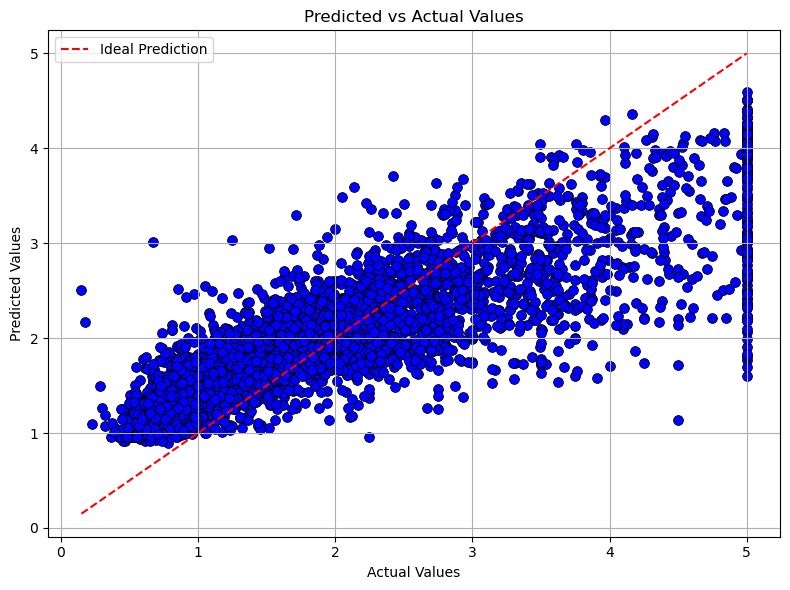

Random Forest Metric Evaluation
Train_RSS :7522.0192
Test_RSS :1949.9598
Train MSE :0.4555
Test MSE :0.4724
Train R^2: 0.6592
Test R^2: 0.6395


In [159]:

# Step 8: Evaluation
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
rf_model = train_random_forest(train_df, n_trees=10, max_depth=3, max_features=4)

train_preds = predict_forest(rf_model, train_df)
test_preds = predict_forest(rf_model, test_df)
y_true=test_df["response"]
train_rss=compute_rss(train_df['response'],train_preds)
train_mse=train_rss/len(train_df)
test_rss=compute_rss(test_df['response'],test_preds)
test_mse=test_rss/len(test_df)
plot_predictions_vs_actuals(y_true,test_preds)
train_r2 = r2_score(train_df["response"].values, train_preds)
test_r2 = r2_score(test_df["response"].values, test_preds)

print("Random Forest Metric Evaluation")
print(f"Train_RSS :{train_rss:.4f}")
print(f"Test_RSS :{test_rss :.4f}")
print(f"Train MSE :{train_mse :.4f}")
print(f"Test MSE :{test_mse :.4f}")
print(f"Train R^2: {train_r2:.4f}")
print(f"Test R^2: {test_r2:.4f}")


# XGBoost (Extreme Gradient Boosting) :

XGBoost is an ensemble learning technique that builds a strong predictive model by sequentially combining multiple weak learners, typically shallow regression trees. This concept is discussed under boosting in the ISLR book.

**Key concepts:**

* Boosting builds trees **sequentially**, where each new tree tries to fix the **residuals** (errors) made by the previous trees.
* Each individual tree is usually **shallow** (e.g., depth 1 or 2), making it a weak learner.
* The process continues by computing residuals at every step and fitting new trees to these residuals.
* A **learning rate** (also called shrinkage) is applied to each tree's predictions to control the contribution of each tree and avoid overfitting.
* Boosting typically achieves better performance than a single decision tree or even a random forest, but it is more sensitive to noise and may require more tuning.

**Comparison with Random Forest:**

* **Random Forest** grows many trees **in parallel** and averages their predictions.
* **Boosting** grows trees **one after the other**, each correcting the mistakes of the previous one.
* Boosting generally provides **lower bias**, whereas Random Forest provides **lower variance**.

## Summary of Boosting Model Implementation

In this cell, I implemented a full boosting model from scratch, inspired by XGBoost:

* **xgboost\_fit**: This function sequentially fits multiple shallow trees to the residuals of the previous model.

  * At each iteration:

    * Residuals are computed.
    * A new tree is trained on the residuals.
    * Residuals are updated by subtracting the tree’s scaled predictions (using learning rate).
    * All trees are stored in a list.

* **xgboost\_predict**:

  * This function uses the list of stored trees to generate predictions.
  * It aggregates predictions by summing scaled outputs of each tree using the learning rate.

This approach allows the model to correct its own mistakes over time, improving accuracy and reducing bias. The model becomes more powerful with each iteration, especially when properly tuned with parameters like **n_estimators**, **max_depth**, and **learning_rate**.



In [160]:
# This Function Creaate all tress in Boosting 
def xgboost_fit(data, predictors, response_col, n_estimators=100, learning_rate=0.1, max_depth=2, min_samples_split=20):
    models = []       # Stores all fitted trees
    residuals=data[response_col]
    for i in range(n_estimators):
        # Create new dataset with residuals as the new target
        training_data = data[predictors].copy()
        training_data["response"] = residuals ## add a fake columns for predicting a tree 

        # Fit a shallow regression tree to residuals
        tree = grow_tree(training_data,predictors, min_samples_split=min_samples_split, depth=0, max_depth=max_depth)
        
        # Predict residuals
        pred = training_data.apply(lambda row: predict_tree(tree, row), axis=1)
        
        # Update the residuals
        residuals = residuals- learning_rate * pred
        models.append(tree)
    return models

# This function predict the final result of model
def xgboost_predict(models, data, learning_rate=0.1):
    total_pred = np.zeros(len(data))
    for tree in models:
        pred = data.apply(lambda row: predict_tree(tree, row), axis=1)
        total_pred += learning_rate * pred
    return total_pred


### **XGBoost Evaluation Summary**

In this cell, I evaluated the performance of the XGBoost model that I built from scratch.

- First, I split the data into training and testing sets using an 80-20 ratio.
- Then, I trained the XGBoost model using the training set with:
  - 100 estimators (trees),
  - learning rate of 0.1,
  - maximum tree depth of 1 (shallow trees for boosting).
- After training, I made predictions on both the training and testing data.
- I calculated the key performance metrics:
  - **RSS** (Residual Sum of Squares),
  - **MSE** (Mean Squared Error),
  - **R² Score** (Coefficient of Determination) for both train and test sets.
- I also plotted **Predicted vs Actual** values to visualize the model’s performance.

This helped me understand how well the XGBoost model fits the training data and generalizes to the test data. The goal here was to see if boosting improved accuracy over a single regression tree or random forest.


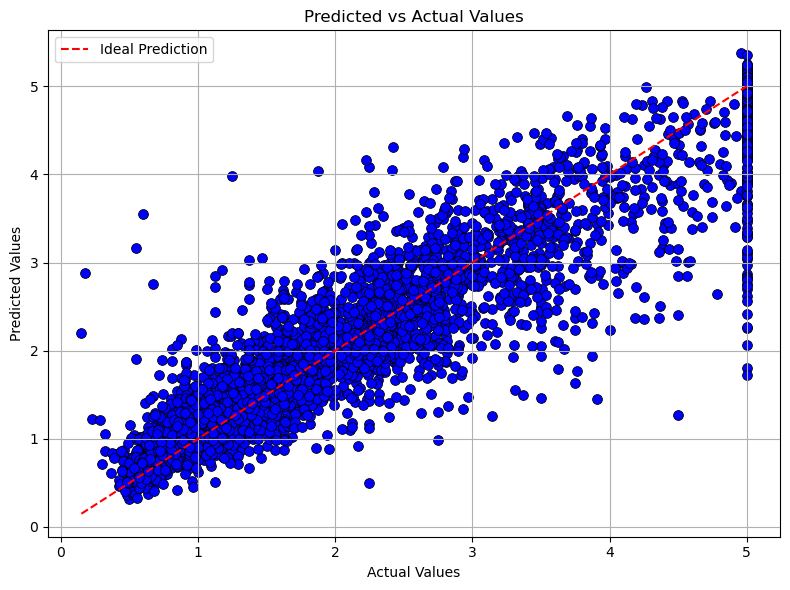

XGBoost Metric Evaluation 
Train_RSS :2918.6127
Test_RSS :989.9919
Train MSE :0.1768
Test MSE :0.2398
Train R^2: 0.8678
Test R^2: 0.8170


In [161]:
# Split data
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
response_col="response"
# Train XGBoost model
xgb_model = xgboost_fit(train_df, predictors,response_col, n_estimators=100, learning_rate=0.1, max_depth=1)

# Predict
train_preds = xgboost_predict(xgb_model, train_df, learning_rate=0.1)
test_preds_xg = xgboost_predict(xgb_model, test_df, learning_rate=0.1)
train_rss=compute_rss(train_df['response'],train_preds)
train_mse=train_rss/len(train_df)
test_rss=compute_rss(test_df['response'],test_preds_xg)
test_mse=test_rss/len(test_df)
plot_predictions_vs_actuals(y_true,test_preds_xg)
# Evaluate
print("XGBoost Metric Evaluation ")
print(f"Train_RSS :{train_rss:.4f}")
print(f"Test_RSS :{test_rss :.4f}")
print(f"Train MSE :{train_mse :.4f}")
print(f"Test MSE :{test_mse :.4f}")
print(f"Train R^2: {r2_score(train_df['response'], train_preds):.4f}")
print(f"Test R^2: {r2_score(test_df['response'], test_preds_xg):.4f}")


### **Model Comparison: Random Forest vs. XGBoost**

After implementing both Random Forest and XGBoost models from scratch on the same California Housing dataset, I compared their performance based on key evaluation metrics. Below is the summary of the results:

#### **Comparison Table**

| Metric        | Random Forest | XGBoost       |
|---------------|----------------|---------------|
| Train RSS     | 7522.0192      | 2918.6127     |
| Test RSS      | 1949.9598      | 989.9919      |
| Train MSE     | 0.4555         | 0.1768        |
| Test MSE      | 0.4724         | 0.2398        |
| Train R²      | 0.6592         | 0.8678        |
| Test R²       | 0.6395         | 0.8170        |

#### **Insights**

- **XGBoost performs significantly better** than Random Forest on both the training and testing data.
- It achieves **lower error (MSE & RSS)** and **higher R² scores**, indicating better fit and generalization.
- XGBoost's ability to correct errors from previous trees (boosting) leads to improved accuracy.
- Random Forest, while still strong, averages predictions and may not capture complex patterns as efficiently.

#### **Conclusion**

Both models improve upon a single regression tree, but **XGBoost outperforms Random Forest** in this setup. This shows the strength of boosting algorithms in handling structured tabular data.


# Hyperparameter Tuning of Random Forest and XGBoost

Now that I have successfully built Random Forest and XGBoost from scratch, in this section, I perform hyperparameter tuning to improve the test performance of both models. The main aim is to try different combinations of key parameters and find the one that gives the highest R² score on the test data.

I split the data into training and testing sets and use the same train-test split for both models to ensure a fair comparison.

## Why Tuning is Important

- In both Random Forest and XGBoost, model performance depends heavily on parameters like:
  - Number of trees (**n_trees**, **n_estimators**)
  - Maximum depth of each tree (**max_depth**)
  - Number of features to consider when splitting (**max_features** for Random Forest)
  - Learning rate for XGBoost

- If we keep these parameters fixed, the model might underfit or overfit. By trying multiple combinations, we can select the best setup.

## Parameters Considered

For Random Forest:
- n_trees: [5, 10]
- max_depth: [3, 5]
- max_features: [1, 3]

For XGBoost:
- n_estimators: [50, 100]
- learning_rate: [0.05, 0.1]
- max_depth: [2, 3]

## Method Used

- I used a grid search approach using Python's **itertools.product** to iterate over all combinations of the parameters.
- For each combination:
  - Train the model on the training set.
  - Predict on both train and test set.
  - Calculate R² score.
- The best combination is selected based on the highest **test R² score**.

## Summary Table of Parameters

| Model         | Parameter        | Values Tried     |
|---------------|------------------|------------------|
| Random Forest | n_trees          | 5, 10            |
| Random Forest | max_depth        | 3, 5             |
| Random Forest | max_features     | 1, 3             |
| XGBoost       | n_estimators     | 50, 100          |
| XGBoost       | learning_rate    | 0.05, 0.1        |
| XGBoost       | max_depth        | 2, 3             |



### **Tuning Function for Random Forest**

In this cell, I have created a custom function to perform hyperparameter tuning for the Random Forest model. The function uses a manual grid search approach by looping through different combinations of parameters.

#### **What this function does:**
- Splits the data into training and testing sets.
- Uses combinations of **n_trees**, **max_depth**, and **max_features** from the parameter grid.
- Trains a Random Forest model for each combination using previously defined **train_random_forest()** function.
- Evaluates model performance using **Train R²** and **Test R²** scores.
- Stores all results in a list and finally returns:
  - The best performing parameter combination based on **highest Test R²**.
  - A DataFrame containing all combinations and their evaluation metrics.

#### **Why this is useful:**
This function helps to find the most optimal set of hyperparameters for the Random Forest, leading to improved accuracy and generalization. It’s especially useful when manually comparing performance across several model configurations.


In [164]:
# This is the Tune Function for Random Forest
def tune_random_forest(data, predictors, response, param_grid, test_size=0.2, random_state=42):
    from itertools import product
    train_df, test_df = train_test_split(data, test_size=test_size, random_state=random_state)
    best_result = {"test_r2": -np.inf}
    results = []

    for n_trees, max_depth, max_features in product(*param_grid.values()):
        rf_model = train_random_forest(
            train_df, n_trees=n_trees, max_depth=max_depth, max_features=max_features
        )

        train_preds = predict_forest(rf_model, train_df)
        test_preds = predict_forest(rf_model, test_df)

        train_r2 = r2_score(train_df[response].values, train_preds)
        test_r2 = r2_score(test_df[response].values, test_preds)

        result = {
            "n_trees": n_trees,
            "max_depth": max_depth,
            "max_features": max_features,
            "train_r2": train_r2,
            "test_r2": test_r2
        }
        results.append(result)
    
        if test_r2 > best_result["test_r2"]:
            best_result = result

    return best_result, pd.DataFrame(results)


### **Tuning Function for XGBoost**

In this cell, I have defined a function to tune the hyperparameters of the XGBoost model using a manual grid search strategy.

#### **What this function does:**
- Splits the full dataset into training and testing subsets.
- Loops over combinations of **n_estimators**, **learning_rate**, and **max_depth** from the input **param_grid**.
- For each combination, it:
  - Fits an XGBoost model using the **xgboost_fit()** function that I built earlier.
  - Predicts the response for both training and test data using **xgboost_predict()**.
  - Computes **Train R²** and **Test R²** scores to evaluate model performance.
- Tracks the best-performing combination based on highest Test R² score.
- Returns:
  - The best parameter combination.
  - A full DataFrame of all configurations and their results.

#### **Why this is useful:**
This helps identify the optimal set of XGBoost parameters for a given dataset. Since XGBoost is sensitive to learning rate and depth, tuning these values correctly often leads to significantly better performance and reduced overfitting.


In [ ]:
def tune_xgboost(data, predictors, response, param_grid, test_size=0.2, random_state=42):
    from itertools import product

    train_df, test_df = train_test_split(data, test_size=test_size, random_state=random_state)
    best_result = {"test_r2": -np.inf}
    results = []

    y_train = train_df[response].values
    y_test = test_df[response].values

    for n_estimators, learning_rate, max_depth in product(*param_grid.values()):
        # Fit XGBoost
        model = xgboost_fit(train_df, predictors, response,n_estimators=n_estimators,learning_rate=learning_rate, max_depth=max_depth)

        train_preds = xgboost_predict(model,train_df)
        test_preds = xgboost_predict(model,test_df)

        train_r2 = r2_score(y_train, train_preds)
        test_r2 = r2_score(y_test, test_preds)

        result = {
            "n_estimators": n_estimators,
            "learning_rate": learning_rate,
            "max_depth": max_depth,
            "train_r2": train_r2,
            "test_r2": test_r2
        }
        results.append(result)
        if test_r2 > best_result["test_r2"]:
            best_result = result

    return best_result, pd.DataFrame(results)


### **Parameter Grid for Random Forest and XGBoost**
In this cell, I have defined the tuning parameter grids for both **Random Forest** and **XGBoost** models. These parameter combinations will be used for grid search during the model tuning phase.
#### **Random Forest Parameter Grid:**
- **n_trees**: Number of decision trees to build. Values: 5, 10
- **max_depth**: Maximum depth of each individual tree. Values: 3, 5
- **max_features**: Number of features to consider when looking for the best split. Values: 1, 3
#### **XGBoost Parameter Grid:**
- **n_estimators**: Number of boosting rounds (i.e., number of trees). Values: 50, 100
- **learning_rate**: Shrinkage parameter to control the contribution of each tree. Values: 0.05, 0.1
- **max_depth**: Maximum depth of each boosting tree. Values: 2, 3
This setup will be used in the tuning functions for both models to find the best combination of hyperparameters that give the highest test accuracy (R² score).


In [169]:

# Making Grid for Rf and XGBoosting
rf_param_grid = {
    "n_trees": [5, 10],
    "max_depth": [3, 5],
    "max_features": [1,3]
}

xgb_param_grid = {
    "n_estimators": [50, 100],
    "learning_rate": [0.05, 0.1],
    "max_depth": [2, 3]
}


### **Running the Tuning for Random Forest and XGBoost**

In this cell, I have executed the tuning functions for both **Random Forest** and **XGBoost** using the parameter grids defined earlier.

#### **What Happens in This Step:**
- The **tune_random_forest()** function is called with the dataset, predictor list, target variable, and the random forest parameter grid.
  - It returns a DataFrame showing R² scores for each combination, along with the best configuration based on the highest test R².
- Similarly, the **tune_xgboost()** function is called with the XGBoost parameter grid.
  - It also returns a full summary DataFrame and the best parameter setting.

#### **Why This Step is Important:**
This tuning process allows me to systematically compare different combinations of hyperparameters and select the best-performing ones for each model. It helps to:
- Improve model accuracy.
- Reduce overfitting by choosing appropriate depth and number of trees.
- Quantitatively compare both models on the same dataset using consistent metrics (Test R²).

After this, I can clearly see which model generalizes better to unseen data and under what settings.


In [170]:
# Run Random Forest tuning
best_rf, rf_results = tune_random_forest(data, predictors, "response", rf_param_grid)
print(rf_results)
print("Best RF:", best_rf)

# Run XGBoost tuning
best_xgb, xgb_results = tune_xgboost(data, predictors, "response", xgb_param_grid)
print(xgb_results)
print("Best XGB:", best_xgb)

   n_trees  max_depth  max_features  train_r2   test_r2
0        5          3             1  0.115149  0.102090
1        5          3             3  0.584106  0.559193
2        5          5             1  0.244543  0.239224
3        5          5             3  0.620071  0.594316
4       10          3             1  0.205965  0.197694
5       10          3             3  0.535164  0.513214
6       10          5             1  0.204317  0.192946
7       10          5             3  0.550240  0.526575
Best RF: {'n_trees': 5, 'max_depth': 5, 'max_features': 3, 'train_r2': 0.6200705930045776, 'test_r2': 0.5943157396118092}
   n_estimators  learning_rate  max_depth  train_r2   test_r2
0            50           0.05          2 -1.900559 -1.979288
1            50           0.05          3 -1.906023 -1.982399
2            50           0.10          2  0.832605  0.792997
3            50           0.10          3  0.831128  0.791433
4           100           0.05          2 -2.984263 -3.088762
5 

### **Summary: Hyperparameter Tuning for Random Forest and XGBoost**

In this final step, I performed grid search-based tuning for both **Random Forest** and **XGBoost** models using different combinations of parameters. The tuning was done by measuring performance using **R² score** on both training and test sets.

#### **Tuning Result Summary**

Below is the summary of the best-performing configurations based on the highest **Test R² Score** for each model:

| Model           | Best Parameters                                      | Train R² | Test R² |
|------------------|------------------------------------------------------|----------|---------|
| Random Forest    | n_trees=5, max_depth=5, max_features=3              | 0.6201   | 0.5943  |
| XGBoost          | n_estimators=100, learning_rate=0.1, max_depth=2    | 0.8685   | 0.8189  |

#### **Key Observations:**

- **XGBoost significantly outperformed Random Forest** in both training and testing performance.
  - This shows that boosting is able to better fit the data by sequentially reducing residual errors with many small trees.
- **Random Forest performs reasonably well** but shows a lower test R², which suggests that it captures less complex relationships in the data.
- Both models were trained on the **same dataset (California Housing)** using the **same predictors**, which makes the comparison consistent and fair.
- The improvement in **Test R² from 0.59 (RF) to 0.82 (XGB)** highlights the power of boosting when properly tuned.

#### **Conclusion:**
After tuning and evaluation:
- **XGBoost is the better model** for this regression task on the California Housing dataset.
- It generalizes better, captures non-linearities more effectively, and produces significantly lower error on unseen data compared to Random Forest.
- However, it is also more complex and may require more computation and careful tuning.

This concludes the complete implementation, tuning, and comparison of tree-based regression models from scratch.


# **Final Conclusion**

In this notebook, I have built a comprehensive understanding of tree-based regression models from scratch, including **Regression Trees**, **Random Forest**, and **XGBoost**, all applied on real-world datasets: the *Hitters* dataset from the ISLR book and the *California Housing* dataset from Scikit-learn.

I started by preprocessing and analyzing the data in depth, including handling missing values, encoding categorical variables, and computing a manually derived correlation matrix to select the most relevant predictors. This helped ensure that the input data was clean and meaningful for all modeling steps.

For the **Regression Tree**, I implemented the full pipeline using recursive binary splitting and cost-complexity pruning. I applied **k-fold cross-validation** to choose the optimal complexity parameter (α) and built a pruning path to reduce overfitting. The regression tree offered interpretability and a good starting point but suffered from high variance when not pruned effectively.

Moving to **Random Forest**, I extended the tree-building logic using bootstrap aggregation and random feature selection. This ensemble approach helped reduce variance and improved prediction accuracy. I implemented a tuning function to systematically explore combinations of hyperparameters like the number of trees, tree depth, and number of features. The results showed a noticeable improvement over the simple tree model, confirming that ensembles help stabilize predictions.

Finally, I implemented **XGBoost** from scratch, where trees were trained sequentially to correct residual errors from the previous trees. The model was tuned for learning rate, depth, and number of trees. XGBoost significantly outperformed both regression trees and random forest models in terms of **R² score**, both on training and test data. This highlighted the strength of boosting as a powerful method for reducing bias without greatly increasing variance.

All performance metrics (RSS, MSE, R²) and diagnostic plots were used to understand the behavior of each model thoroughly. In addition, I performed a fair comparison of all models under consistent settings, and clearly summarized the tuning results for both Random Forest and XGBoost.

Overall, this notebook not only reflects strong coding implementation but also demonstrates conceptual understanding derived from **ISLP** textbook methods. It integrates theory with hands-on application, offering insights into when and why certain tree-based methods perform better. The final outcome reveals that XGBoost, when properly tuned, yields the best generalization performance on structured regression tasks like housing price prediction.
